In [1]:
import subprocess
import shlex
import re
import json

import numpy as np
import multiprocessing as mp

from matplotlib import pyplot as plt
from scipy import stats
from tqdm import tqdm
from IPython.display import display, Markdown
from tempfile import TemporaryDirectory

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

def show():
    plt.savefig(f"independent.{show.fig_counter}.pdf", dpi='figure', transparent=True, bbox_inches='tight')
    show.fig_counter += 1
    show.plt_show()

show.fig_counter = 0
show.plt_show = plt.show

plt.show = show

In [3]:
import scipy.special as sp

def s_island(A_eff, deme, nu):
    theta_A_eff = (deme * A_eff - 1.0) * nu / (1.0 - nu)
    
    return theta_A_eff * (sp.digamma(theta_A_eff + deme * A_eff) - sp.digamma(theta_A_eff))

def s_island_limit(A_eff, deme, nu):
    return ((A_eff * deme - 1.0) * nu * np.log(1.0 / nu)) / (1.0 - nu)

In [4]:
BIODIVERSITY_PATTERN = re.compile(r"The simulation resulted in a biodiversity of (\d+) unique species\.")
TIMING_PATTERN = re.compile(r"The simulation finished at time (\d+\.\d+) after (\d+) steps\.")

In [5]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

In [6]:
def simulate_non_spatial_monolithic(algorithm, speciation=0.1, seed=42, size=(10, 10, 10), spatial=False):
    config = "".join(f"""
    (
        speciation: {speciation},
        sample: 1.0,
        seed: {seed},

        algorithm: {algorithm},

        log: None,

        scenario: NonSpatial(
            area: ({size[0]}, {size[1]}),
            deme: {size[2]},
            spatial: {str(spatial).lower()},
        ),

        reporters: [
            Plugin(
                library: "{target_directory}/release/deps/libnecsim_plugins_common.so",
                reporters: [Biodiversity()]
            )
        ],
    )
    """.split()).replace(",)", ")").replace(",]", "]")

    # Run the simulation
    result = subprocess.run(shlex.split(
        "cargo run --release --features rustcoalescence-algorithms-monolithic,"
        + "rustcoalescence-algorithms-independent,necsim-partitioning-mpi "
        + f"--quiet -- simulate '{config}'"
    ), check=True, capture_output=True, text=True)

    match = BIODIVERSITY_PATTERN.search(result.stdout)
    if match is None:
        print(result.stdout)
        print(result.stderr)
    biodiversity = int(match.group(1))

    match = TIMING_PATTERN.search(result.stdout)
    if match is None:
        print(result.stdout)
        print(result.stderr)
    time = float(match.group(1))
    steps = int(match.group(2))
        
    return biodiversity, time, steps

In [7]:
def simulate_non_spatial_parallel(algorithm, partitions=4, speciation=0.1, seed=42, size=(10, 10, 10), spatial=False):
    with TemporaryDirectory() as log:
        config = "".join(f"""
        (
            speciation: {speciation},
            sample: 1.0,
            seed: {seed},

            algorithm: {algorithm},

            log: "{log}",

            scenario: NonSpatial(
                area: ({size[0]}, {size[1]}),
                deme: {size[2]},
                spatial: {str(spatial).lower()},
            ),

            reporters: [
                Plugin(
                    library: "{target_directory}/release/deps/libnecsim_plugins_common.so",
                    reporters: [Biodiversity()]
                )
            ],
        )
        """.split()).replace(",)", ")").replace(",]", "]")

        # Run the simulation
        result = subprocess.run(shlex.split(
            "cargo mpirun --release --features rustcoalescence-algorithms-monolithic,"
            + "rustcoalescence-algorithms-independent,necsim-partitioning-mpi --bin rustcoalescence "
            + f"-n {partitions} -- simulate '{config}'"
        ), capture_output=True, text=True)
        
        match = TIMING_PATTERN.search(result.stdout)
        if match is None:
            print(result.stdout)
            print(result.stderr)
        time = float(match.group(1))
        steps = int(match.group(2))
        
        config = "".join(f"""
        (
            logs: ["{log}/*/*"],

            reporters: [
                Plugin(
                    library: "{target_directory}/release/deps/libnecsim_plugins_common.so",
                    reporters: [Biodiversity()]
                )
            ],
        )
        """.split()).replace(",)", ")").replace(",]", "]")
        
        # Run the simulation
        result = subprocess.run(shlex.split(
            "cargo run --release --features rustcoalescence-algorithms-monolithic,"
            + f"rustcoalescence-algorithms-independent,necsim-partitioning-mpi --quiet -- replay '{config}'"
        ), check=True, capture_output=True, text=True)

        match = BIODIVERSITY_PATTERN.search(result.stdout)
        if match is None:
            print(result.stdout)
            print(result.stderr)
        biodiversity = int(match.group(1))
        
    return biodiversity, time, steps

In [8]:
def simulate_non_spatial_isolated(algorithm, partitions=4, speciation=0.1, seed=42, size=(10, 10, 10), spatial=False):
    with TemporaryDirectory() as log:
        def simulate_non_spatial_isolated_partition(rank):
            config = "".join(f"""
            (
                speciation: {speciation},
                sample: 1.0,
                seed: {seed},

                algorithm: {algorithm.format(partition=f'Partition(rank:{rank},partitions:{partitions})')},

                log: "{log}/{rank}",

                scenario: NonSpatial(
                    area: ({size[0]}, {size[1]}),
                    deme: {size[2]},
                    spatial: {str(spatial).lower()},
                ),

                reporters: [
                    Plugin(
                        library: "{target_directory}/release/deps/libnecsim_plugins_common.so",
                        reporters: [Biodiversity()]
                    )
                ],
            )
            """.split()).replace(",)", ")").replace(",]", "]")
            
            # Run the simulation
            result = subprocess.run(shlex.split(
                "cargo run --release --features rustcoalescence-algorithms-monolithic,"
                + "rustcoalescence-algorithms-independent,necsim-partitioning-mpi "
                + f"-- simulate '{config}'"
            ), capture_output=True, text=True)
        
            match = TIMING_PATTERN.search(result.stdout)
            if match is None:
                print(result.stdout)
                print(result.stderr)
            time = float(match.group(1))
            steps = int(match.group(2))
            
            return time, steps

        results = [simulate_non_spatial_isolated_partition(rank) for rank in range(partitions)]
            
        times, steps = tuple(zip(*results))
        
        config = "".join(f"""
        (
            logs: ["{log}/*/*/*"],

            reporters: [
                Plugin(
                    library: "{target_directory}/release/deps/libnecsim_plugins_common.so",
                    reporters: [Biodiversity()]
                )
            ],
        )
        """.split()).replace(",)", ")").replace(",]", "]")
        
        # Run the simulation
        result = subprocess.run(shlex.split(
            "cargo run --release --features rustcoalescence-algorithms-monolithic,"
            + f"rustcoalescence-algorithms-independent,necsim-partitioning-mpi --quiet -- replay '{config}'"
        ), check=True, capture_output=True, text=True)

        match = BIODIVERSITY_PATTERN.search(result.stdout)
        if match is None:
            print(result.stdout)
            print(result.stderr)
        biodiversity = int(match.group(1))
        
    return biodiversity, max(times), sum(steps)

In [9]:
def batch_simulation_many_seeds(simulate, seeds, args=tuple(), kwargs=dict(), silent=False, processes=mp.cpu_count()):
    results = []

    with tqdm(total=len(seeds), disable=silent) as progress:
        def update_progress(result):
            results.append(result)

            progress.update()
        
        def update_error(err):
            print(err)

        with mp.Pool(processes) as pool:
            for seed in seeds:
                pool.apply_async(simulate, args, {**kwargs, "seed": seed}, update_progress, update_error)

            pool.close()
            pool.join()
    
    return results

In [10]:
def confidenceInterval(a, conf=0.95):
    mean = np.mean(a)
    sem = stats.sem(a)
    
    t = stats.t.ppf((1.0 + conf) * 0.5, len(a) - 1)
    
    return mean - t*sem, mean + t*sem

In [11]:
def visualise_biodiversity_time_steps_result(expected, biodiversities, times, steps, conf=0.95):
    low, high = confidenceInterval(biodiversities, conf=conf)

    xmin = np.min(biodiversities)
    xmax = np.max(biodiversities)

    bins = min(21, xmax - xmin + (1 - (xmax - xmin) % 2))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

    ax1.set_title("Biodiversity distribution")
    ax1.set_xlabel("biodiversity")
    ax1.set_ylabel("pdf")
    ax1.hist(biodiversities, bins=bins, density=True, label=(
        f"Observed: {round((low + high) * 0.5, 2)} ± {round((high - low) * 0.5, 2)} ({conf} level)"
    ))
    ax1.axvline(x=expected, color='red', label=f"Expected: {round(expected, 2)}")

    mu, std = stats.norm.fit(biodiversities)
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    ax1.plot(x, p, 'k', linewidth=2, label=f"Fitted: mu≈{round(mu, 2)} sigma≈{round(std, 2)}")

    ax1.legend(loc = 'lower center')

    ax2.set_title("Simulation time distribution")
    ax2.set_xlabel("time")
    ax2.set_ylabel("pdf")
    ax2.hist(times, bins=bins, density=True)

    ax3.set_title("Simulation steps distribution")
    ax3.set_xlabel("steps")
    ax3.set_ylabel("pdf")
    ax3.hist(steps, bins=bins, density=True)

    plt.show()

# I. Verify that different `delta_t`s for the Independent Algorithm give the correct results for a NonSpatial scenario

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:25<00:00, 11.65it/s]


## Independent(delta_t:0.5):

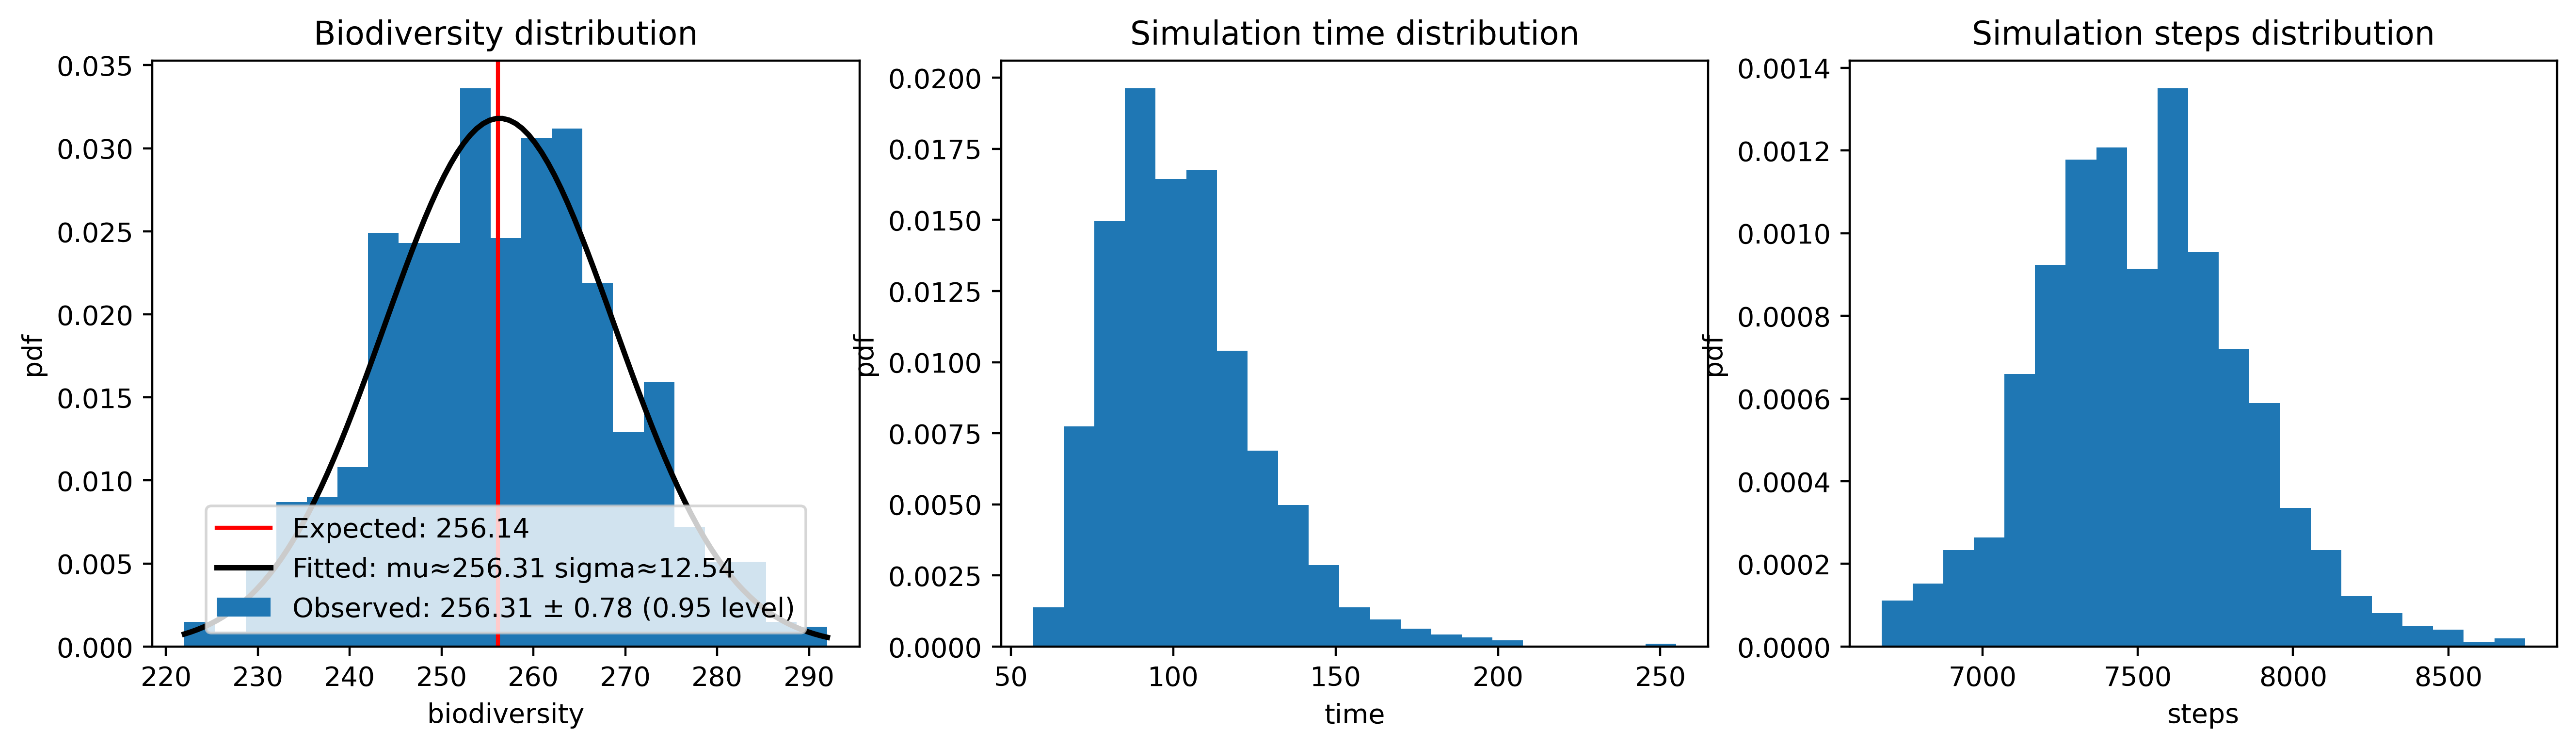

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:26<00:00, 11.63it/s]


## Independent(delta_t:5.0):

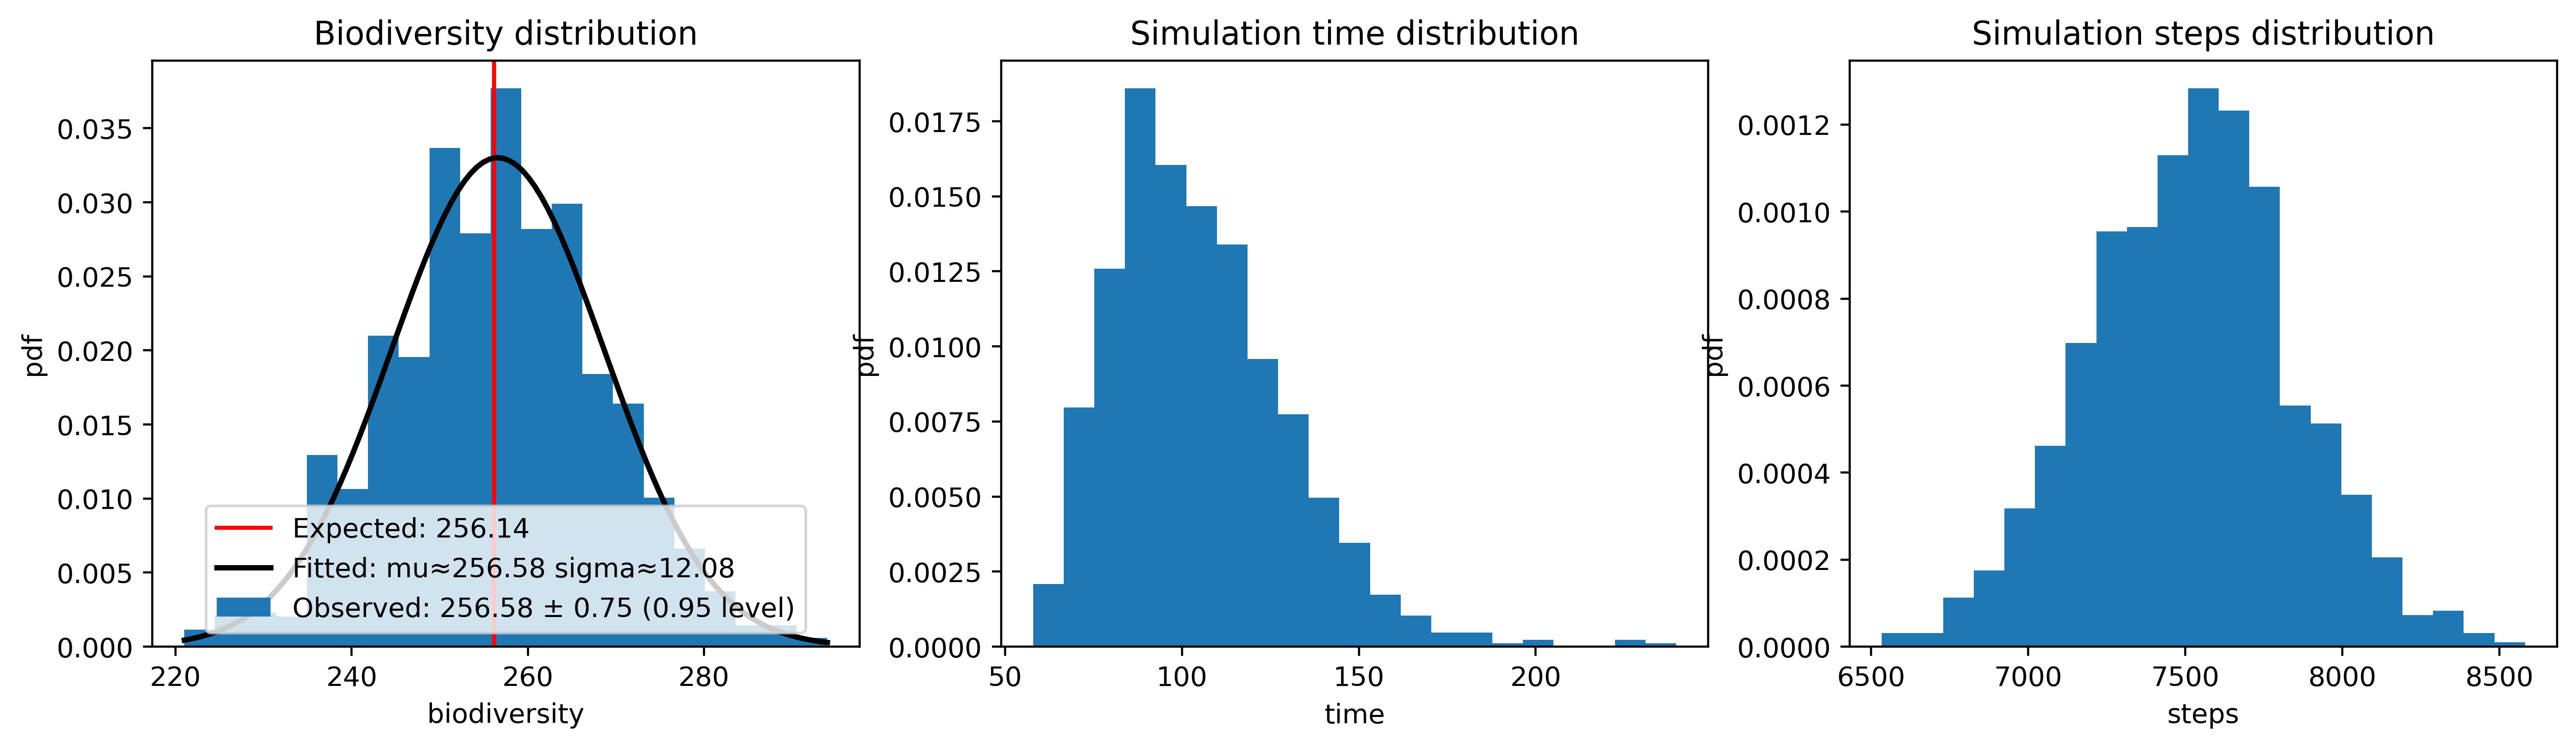

In [12]:
for algorithm in ["Independent(delta_t:0.5)", "Independent(delta_t:5.0)"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000)

    results = batch_simulation_many_seeds(simulate_non_spatial_monolithic, seeds, args=(algorithm,), kwargs={
        "size":(10, 10, 10), "speciation":0.1
    }, silent=False)

    biodiversities, times, steps = tuple(zip(*results))

    display(Markdown(f"## {algorithm}:"))
    visualise_biodiversity_time_steps_result(s_island(10*10, 10, 0.1), biodiversities, times, steps)

# II. Verify that the default settings for the Independent Algorithm give the correct results for a NonSpatial scenario without parallelisation

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:27<00:00, 11.38it/s]


## Independent():

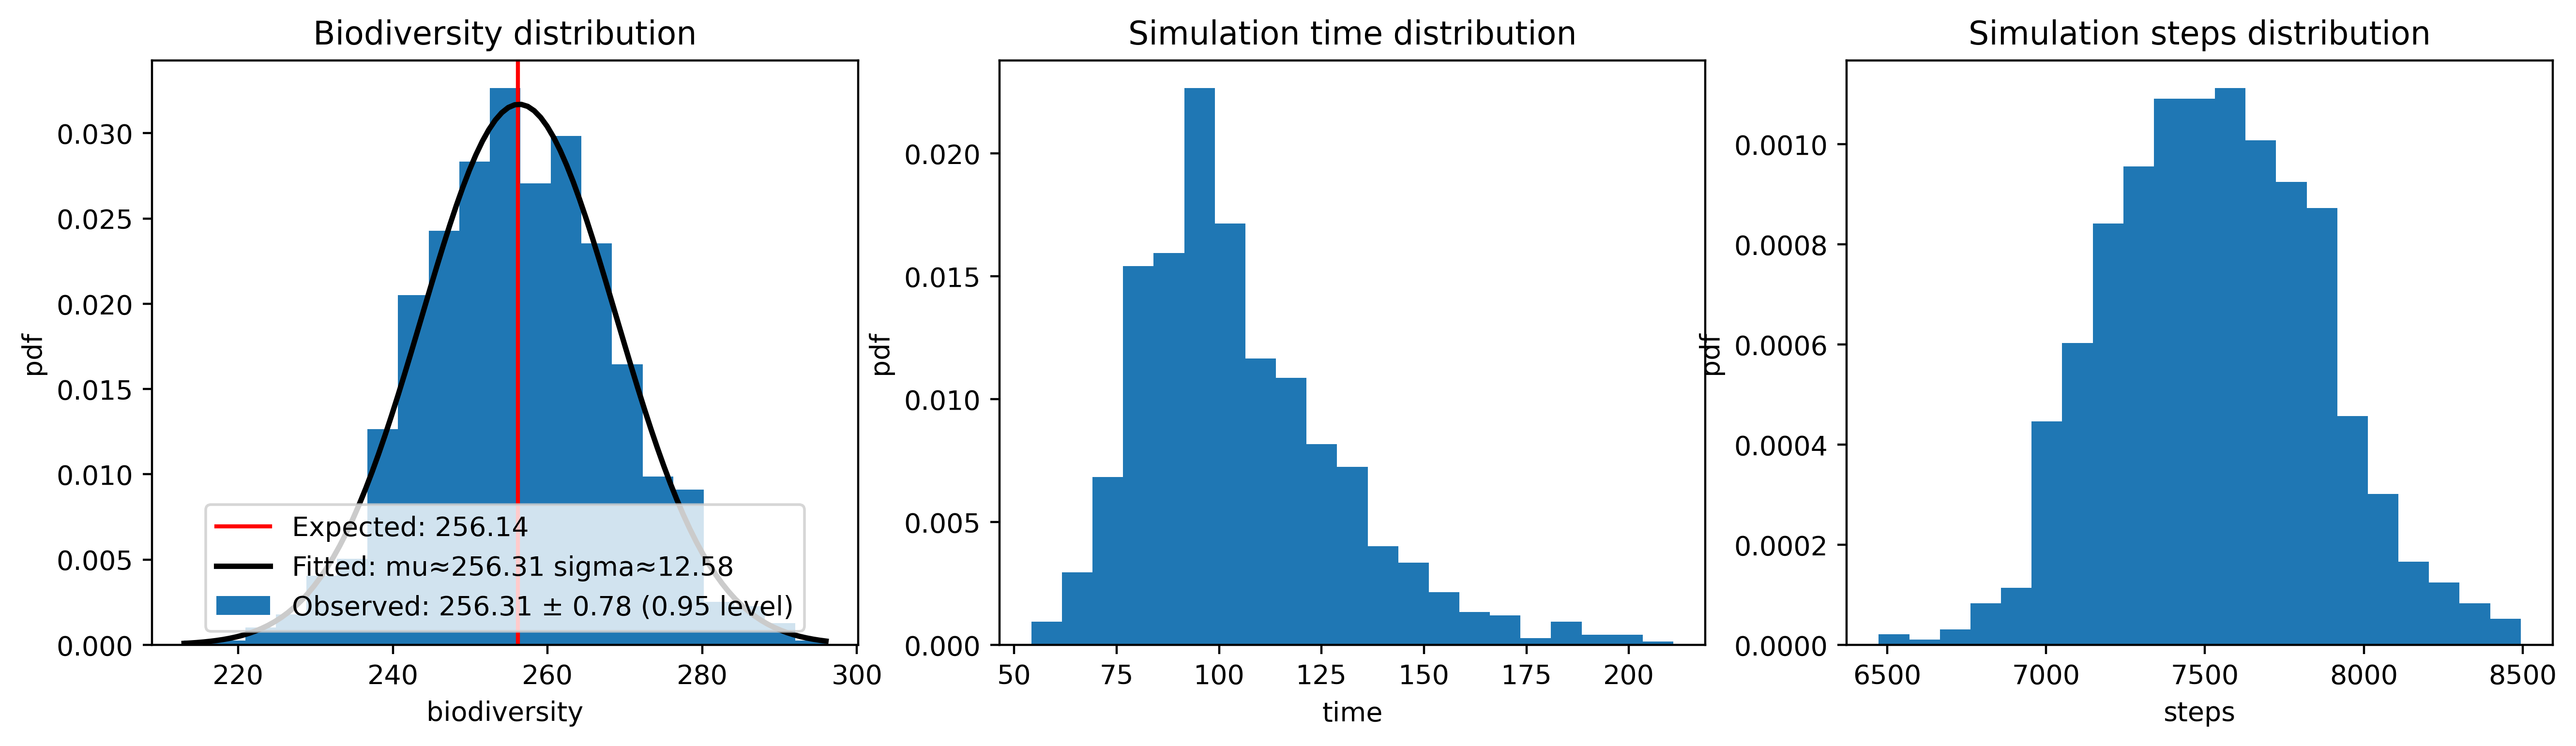

In [13]:
for algorithm in ["Independent()"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000)

    results = batch_simulation_many_seeds(simulate_non_spatial_monolithic, seeds, args=(algorithm,), kwargs={
        "size":(10, 10, 10), "speciation":0.1
    }, silent=False)

    biodiversities, times, steps = tuple(zip(*results))

    display(Markdown(f"## {algorithm}:"))
    visualise_biodiversity_time_steps_result(s_island(10*10, 10, 0.1), biodiversities, times, steps)

# III. Verify that the non-altering settings produce exactly the same results (excluding #steps)

In [14]:
comparison_seeds = seeds[:]
comparison_results = sorted(r[:2] for r in results[:])

for algorithm in [
    "Independent(step_slice:1)", "Independent(step_slice:25)",
    "Independent(dedup_cache:Absolute(capacity:10))", "Independent(dedup_cache:None)",
    "Independent(parallelism_mode:Monolithic(event_slice:1000))", "Independent(parallelism_mode:Monolithic(event_slice:1))",
]:
    check_results = batch_simulation_many_seeds(simulate_non_spatial_monolithic, comparison_seeds, args=(algorithm,), kwargs={
        "size":(10, 10, 10), "speciation":0.1
    }, silent=False)
    
    check_results = sorted(r[:2] for r in check_results)
    
    if check_results == comparison_results:
        display(Markdown(f"## {algorithm}: <span style='color:green'>Success</span>"))
    else:
        display(Markdown(f"## {algorithm}: <span style='color:red'><u>FAILURE</u></span>"))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:26<00:00, 11.53it/s]


## Independent(step_slice:1): <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:27<00:00, 11.41it/s]


## Independent(step_slice:25): <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:26<00:00, 11.56it/s]


## Independent(dedup_cache:Absolute(capacity:10)): <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:26<00:00, 11.57it/s]


## Independent(dedup_cache:None): <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:26<00:00, 11.51it/s]


## Independent(parallelism_mode:Monolithic(event_slice:1000)): <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:26<00:00, 11.60it/s]


## Independent(parallelism_mode:Monolithic(event_slice:1)): <span style='color:green'>Success</span>

# IV. Verify that the Monolithic replay analysis though the event log produces exactlty the same results as live analysis

In [15]:
comparison_seeds = seeds[:]
comparison_results = sorted(r[:2] for r in results[:])

for algorithm in ["Independent(parallelism_mode:Monolithic(event_slice:100))"]:
    check_results = batch_simulation_many_seeds(simulate_non_spatial_parallel, comparison_seeds, args=(algorithm,), kwargs={
        "partitions":1, "size":(10, 10, 10), "speciation":0.1
    }, silent=False)

    check_results = sorted(r[:2] for r in check_results)

    if check_results == comparison_results:
        display(Markdown(f"## {algorithm}: <span style='color:green'>Success</span>"))
    else:
        display(Markdown(f"## {algorithm}: <span style='color:red'><u>FAILURE</u></span>"))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:02<00:00,  4.12it/s]


## Independent(parallelism_mode:Monolithic(event_slice:100)): <span style='color:green'>Success</span>

# V. Verify that the Isolated parallelisation produces exactly the same results

In [16]:
comparison_seeds = seeds[:]
comparison_results = sorted(r[:2] for r in results[:])

for algorithm in [
    "Independent(parallelism_mode:IsolatedIndividuals(partition:{partition},event_slice:1))",
    "Independent(parallelism_mode:IsolatedIndividuals(partition:{partition},event_slice:1000))",
    "Independent(parallelism_mode:IsolatedLandscape(partition:{partition},event_slice:1))",
    "Independent(parallelism_mode:IsolatedLandscape(partition:{partition},event_slice:1000))",
]:
    for partitions in [2, 5, 40]:
        check_results = batch_simulation_many_seeds(simulate_non_spatial_isolated, comparison_seeds, args=(algorithm,), kwargs={
            "partitions":partitions, "size":(10, 10, 10), "speciation":0.1
        }, silent=False)
        
        check_results = sorted(r[:2] for r in check_results)

        if check_results == comparison_results:
            display(Markdown(f"## {algorithm} with {partitions} partitions: <span style='color:green'>Success</span>"))
        else:
            display(Markdown(f"## {algorithm} with {partitions} partitions: <span style='color:red'><u>FAILURE</u></span>"))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:16<00:00,  3.90it/s]


## Independent(parallelism_mode:IsolatedIndividuals(partition:{partition},event_slice:1)) with 2 partitions: <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:27<00:00,  1.97it/s]


## Independent(parallelism_mode:IsolatedIndividuals(partition:{partition},event_slice:1)) with 5 partitions: <span style='color:green'>Success</span>

 72%|███████████████████████████████████████████████████████████████████████▋                           | 724/1000 [42:50<10:53,  2.37s/it]


    Blocking waiting for file lock on package cache
    Blocking waiting for file lock on build directory
   Compiling necsim-plugins-common v0.1.0 (/home/ml5717/necsim-rust/necsim/plugins/common)
error[E0063]: missing field `raw_total` in initializer of `EventCounterReporter`
   --> necsim/plugins/common/src/event_counter.rs:161:9
    |
161 |         Self {
    |         ^^^^ missing `raw_total`

error: aborting due to previous error

For more information about this error, try `rustc --explain E0063`.
error: could not compile `necsim-plugins-common`

To learn more, run the command again with --verbose.

'NoneType' object has no attribute 'group'

    Blocking waiting for file lock on build directory
   Compiling necsim-plugins-common v0.1.0 (/home/ml5717/necsim-rust/necsim/plugins/common)
error[E0063]: missing field `raw_total` in initializer of `EventCounterReporter`
   --> necsim/plugins/common/src/event_counter.rs:161:9
    |
161 |         Self {
    |         ^^^^ missing `raw_to

 81%|████████████████████████████████████████████████████████████████████████████████▌                  | 814/1000 [50:55<30:36,  9.87s/it]


    Blocking waiting for file lock on build directory
   Compiling necsim-plugins-common v0.1.0 (/home/ml5717/necsim-rust/necsim/plugins/common)
error: 2 positional arguments in format string, but there is 1 argument
   --> necsim/plugins/common/src/event_counter.rs:119:38
    |
119 |               " - Total #events:\n     {} (deduplicated)\n     {} (deduplicated)",
    |                                        ^^                      ^^
120 | /             self.speciation
121 | |                 + self.self_coalescence
122 | |                 + self.out_coalescence
123 | |                 + self.self_dispersal
124 | |                 + self.out_dispersal
125 | |                 + self.late_coalescence
    | |_______________________________________-

error: aborting due to previous error

error: could not compile `necsim-plugins-common`

To learn more, run the command again with --verbose.

'NoneType' object has no attribute 'group'

    Blocking waiting for file lock on build director

 82%|████████████████████████████████████████████████████████████████████████████████▋                  | 815/1000 [51:22<45:50, 14.87s/it]


    Blocking waiting for file lock on package cache
    Blocking waiting for file lock on build directory
   Compiling necsim-plugins-common v0.1.0 (/home/ml5717/necsim-rust/necsim/plugins/common)
error: expected one of `(`, `,`, `.`, `::`, `?`, or an operator, found keyword `self`
   --> necsim/plugins/common/src/event_counter.rs:137:13
    |
136 |             self.self_dispersal
    |                                - expected one of `(`, `,`, `.`, `::`, `?`, or an operator
137 |             self.self
    |             ^^^^ unexpected token

error: aborting due to previous error

error: could not compile `necsim-plugins-common`

To learn more, run the command again with --verbose.

'NoneType' object has no attribute 'group'

    Blocking waiting for file lock on package cache
    Blocking waiting for file lock on build directory
   Compiling necsim-plugins-common v0.1.0 (/home/ml5717/necsim-rust/necsim/plugins/common)
error: expected one of `(`, `,`, `.`, `::`, `?`, or an operator, f

 82%|███████████████████████████████████████████████████████████████████████████████▏                 | 817/1000 [53:59<2:06:23, 41.44s/it]


    Blocking waiting for file lock on build directory
   Compiling necsim-plugins-common v0.1.0 (/home/ml5717/necsim-rust/necsim/plugins/common)
error: unknown character escape: `c`
   --> necsim/plugins/common/src/event_counter.rs:136:81
    |
136 | ...   (same location, with coalescence)\n     {} (different location, no \coalescence)\n     {} (different location, with coalescence)\n ...
    |                                                                           ^ unknown character escape
    |
    = help: for more information, visit <https://static.rust-lang.org/doc/master/reference.html#literals>

error: aborting due to previous error

error: could not compile `necsim-plugins-common`

To learn more, run the command again with --verbose.

'NoneType' object has no attribute 'group'

    Blocking waiting for file lock on build directory
   Compiling necsim-plugins-common v0.1.0 (/home/ml5717/necsim-rust/necsim/plugins/common)
error: unknown character escape: `c`
   --> necsim/plug

 85%|████████████████████████████████████████████████████████████████████████████████████▍              | 853/1000 [57:16<09:52,  4.03s/it]


## Independent(parallelism_mode:IsolatedIndividuals(partition:{partition},event_slice:1)) with 40 partitions: <span style='color:red'><u>FAILURE</u></span>

  7%|███████▏                                                                                            | 72/1000 [00:46<02:17,  6.76it/s]

Command '['cargo', 'run', '--release', '--features', 'rustcoalescence-algorithms-monolithic,rustcoalescence-algorithms-independent,necsim-partitioning-mpi', '--quiet', '--', 'replay', '(logs:["/tmp/tmpptwj_oaz/*/*/*"],reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_common.so",reporters:[Biodiversity()])])']' returned non-zero exit status 101.

    Blocking waiting for file lock on build directory
   Compiling necsim-plugins-common v0.1.0 (/home/ml5717/necsim-rust/necsim/plugins/common)
error: 3 positional arguments in format string, but there are 2 arguments
   --> necsim/plugins/common/src/event_counter.rs:121:20
    |
121 |               \n   - raw:      \n{} (deduplicated)\n     {} (raw)",
    |                      ^^                  ^^                      ^^
122 | /             self.speciation
123 | |                 + self.self_coalescence
124 | |                 + self.out_coalescence
125 | |                 + self.self_dispersal
126 |

 81%|████████████████████████████████████████████████████████████████████████████████▌                  | 814/1000 [06:14<00:41,  4.52it/s]


    Blocking waiting for file lock on build directory
   Compiling necsim-plugins-common v0.1.0 (/home/ml5717/necsim-rust/necsim/plugins/common)
error: unknown character escape: ` `
   --> necsim/plugins/common/src/event_counter.rs:141:65
    |
141 |             \n   - different location, no coalescence:\n     {}\ (different location, no coalescence)\
    |                                                                 ^ unknown character escape
    |
    = help: for more information, visit <https://static.rust-lang.org/doc/master/reference.html#literals>

error: aborting due to previous error

error: could not compile `necsim-plugins-common`

To learn more, run the command again with --verbose.

'NoneType' object has no attribute 'group'

    Blocking waiting for file lock on build directory
   Compiling necsim-plugins-common v0.1.0 (/home/ml5717/necsim-rust/necsim/plugins/common)
error: unknown character escape: ` `
   --> necsim/plugins/common/src/event_counter.rs:141:65
    |
141

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▍    | 954/1000 [07:59<00:11,  4.14it/s]


    Blocking waiting for file lock on package cache
    Blocking waiting for file lock on package cache
    Blocking waiting for file lock on package cache
    Blocking waiting for file lock on package cache
    Blocking waiting for file lock on build directory
   Compiling necsim-plugins-common v0.1.0 (/home/ml5717/necsim-rust/necsim/plugins/common)
error: 3 positional arguments in format string, but there are 2 arguments
   --> necsim/plugins/common/src/event_counter.rs:121:20
    |
121 |               \n   - deduplicated:\n     {}\
    |                      ^^
122 |               \n   - raw:\n     {}",
    |                          ^^^
123 |               self.speciation
    |  ________^^___-
124 | |                 + self.self_coalescence
125 | |                 + self.out_coalescence
126 | |                 + self.self_dispersal
127 | |                 + self.out_dispersal
128 | |                 + self.late_coalescence,
    | |_______________________________________-
129 |    

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▍  | 974/1000 [08:34<00:13,  1.89it/s]


## Independent(parallelism_mode:IsolatedIndividuals(partition:{partition},event_slice:1000)) with 2 partitions: <span style='color:red'><u>FAILURE</u></span>

 18%|█████████████████▎                                                                                 | 175/1000 [01:39<04:51,  2.83it/s]


    Blocking waiting for file lock on package cache
    Blocking waiting for file lock on package cache
    Blocking waiting for file lock on build directory
   Compiling necsim-plugins-common v0.1.0 (/home/ml5717/necsim-rust/necsim/plugins/common)
error[E0063]: missing field `late_dispersal` in initializer of `EventCounterReporter`
   --> necsim/plugins/common/src/event_counter.rs:158:9
    |
158 |         Self {
    |         ^^^^ missing `late_dispersal`

error: aborting due to previous error

For more information about this error, try `rustc --explain E0063`.
error: could not compile `necsim-plugins-common`

To learn more, run the command again with --verbose.

'NoneType' object has no attribute 'group'

    Blocking waiting for file lock on build directory
   Compiling necsim-plugins-common v0.1.0 (/home/ml5717/necsim-rust/necsim/plugins/common)
error[E0063]: missing field `late_dispersal` in initializer of `EventCounterReporter`
   --> necsim/plugins/common/src/event_counter.rs:

 64%|██████████████████████████████████████████████████████████████▊                                    | 635/1000 [08:50<05:04,  1.20it/s]


## Independent(parallelism_mode:IsolatedIndividuals(partition:{partition},event_slice:1000)) with 5 partitions: <span style='color:red'><u>FAILURE</u></span>

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:05:33<00:00,  3.93s/it]


## Independent(parallelism_mode:IsolatedIndividuals(partition:{partition},event_slice:1000)) with 40 partitions: <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:08<00:00,  2.33it/s]


## Independent(parallelism_mode:IsolatedLandscape(partition:{partition},event_slice:1)) with 2 partitions: <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:17<00:00,  1.36it/s]


## Independent(parallelism_mode:IsolatedLandscape(partition:{partition},event_slice:1)) with 5 partitions: <span style='color:green'>Success</span>

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:00:06<00:00,  3.61s/it]


## Independent(parallelism_mode:IsolatedLandscape(partition:{partition},event_slice:1)) with 40 partitions: <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:15<00:00,  3.91it/s]


## Independent(parallelism_mode:IsolatedLandscape(partition:{partition},event_slice:1000)) with 2 partitions: <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:33<00:00,  1.95it/s]


## Independent(parallelism_mode:IsolatedLandscape(partition:{partition},event_slice:1000)) with 5 partitions: <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [56:04<00:00,  3.36s/it]


## Independent(parallelism_mode:IsolatedLandscape(partition:{partition},event_slice:1000)) with 40 partitions: <span style='color:green'>Success</span>

# VI. Verify that the different parallelisation methods produce exactly the same results

In [17]:
comparison_seeds = seeds[:]
comparison_results = sorted(r[:2] for r in results[:])

for algorithm in [
    "Independent(parallelism_mode:Individuals)",
    "Independent(parallelism_mode:Landscape)",
    "Independent(parallelism_mode:Probabilistic(communication: 0.0))",
    "Independent(parallelism_mode:Probabilistic(communication: 0.5))",
    "Independent(parallelism_mode:Probabilistic(communication: 1.0))",
]:
    for partitions in [2, 5, 40]:
        check_results = batch_simulation_many_seeds(simulate_non_spatial_parallel, comparison_seeds, args=(algorithm,), kwargs={
            "partitions":partitions, "size":(10, 10, 10), "speciation":0.1
        }, silent=False, processes=(mp.cpu_count() // partitions))
        
        check_results = sorted(r[:2] for r in check_results)

        if check_results == comparison_results:
            display(Markdown(f"## {algorithm} with {partitions} partitions: <span style='color:green'>Success</span>"))
        else:
            display(Markdown(f"## {algorithm} with {partitions} partitions: <span style='color:red'><u>FAILURE</u></span>"))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:10<00:00,  3.99it/s]


## Independent(parallelism_mode:Individuals) with 2 partitions: <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:16<00:00,  3.90it/s]


## Independent(parallelism_mode:Individuals) with 5 partitions: <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [25:07<00:00,  1.51s/it]


## Independent(parallelism_mode:Individuals) with 40 partitions: <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:08<00:00,  4.02it/s]


## Independent(parallelism_mode:Landscape) with 2 partitions: <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:23<00:00,  3.80it/s]


## Independent(parallelism_mode:Landscape) with 5 partitions: <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [25:17<00:00,  1.52s/it]


## Independent(parallelism_mode:Landscape) with 40 partitions: <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:10<00:00,  3.99it/s]


## Independent(parallelism_mode:Probabilistic(communication: 0.0)) with 2 partitions: <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:17<00:00,  3.88it/s]


## Independent(parallelism_mode:Probabilistic(communication: 0.0)) with 5 partitions: <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [25:10<00:00,  1.51s/it]


## Independent(parallelism_mode:Probabilistic(communication: 0.0)) with 40 partitions: <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:07<00:00,  4.04it/s]


## Independent(parallelism_mode:Probabilistic(communication: 0.5)) with 2 partitions: <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:14<00:00,  3.93it/s]


## Independent(parallelism_mode:Probabilistic(communication: 0.5)) with 5 partitions: <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [25:09<00:00,  1.51s/it]


## Independent(parallelism_mode:Probabilistic(communication: 0.5)) with 40 partitions: <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:04<00:00,  4.09it/s]


## Independent(parallelism_mode:Probabilistic(communication: 1.0)) with 2 partitions: <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:09<00:00,  4.01it/s]


## Independent(parallelism_mode:Probabilistic(communication: 1.0)) with 5 partitions: <span style='color:green'>Success</span>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [25:02<00:00,  1.50s/it]


## Independent(parallelism_mode:Probabilistic(communication: 1.0)) with 40 partitions: <span style='color:green'>Success</span>